# Model Exploration: Logistic Regression Models

<div class="alert alert-info">
<pre>
######################
#
# Submission by Kendrick Lo (Harvard ID: 70984997) for
# AC 209 - Data Science (Profs. H. Pfister, J. Blitzstein, V. Kaynig-Fittkau)
# 
# This is part of a joint project with Amy Lee and Gioia Dominedo.
#
######################
</pre>

Documentation referenced: <br><p>
<ul>
<li>HW3</li>
<li>Lab 11</li>
<li>Sebastian Raschka, <i>Python Machine Learning</i></li>
<li>Sebastian Raschka, Github and Blog (http://sebastianraschka.com/Articles/2014_python_lda.html)</li>
<li>Hui Zou and Trevor Hastie, <i>Regularization and Variable Selection via the Elastic Net</i> (http://web.stanford.edu/~hastie/TALKS/enet_talk.pdf)</li>
</ul>
</div>

# contents

* [data preparation](#data-preparation)
	* [exploring the dataset](#exploring-the-dataset)
	* [creating training and test data sets](#creating-training-and-test-data-sets)
	* [standardization](#standardization)
	* [isolating predictors](#isolating-predictors)
	* [cross-validation](#cross-validation)
	* [looking at the response variable](#looking-at-the-response-variable) <p>

* [modeling](#modeling)
	* [logistic regression with Lasso based feature selection](#logistic-regression-with-Lasso-based-feature-selection)
		* [regularization path](#regularization-path)
        * [interpretation of coefficients](#interpretation-of-coefficients)
	* [ROC curves](#ROC-curves)
	* [elastic net regularized logistic regression](#elastic-net-regularized-logistic-regression)
	* [feature selection using linear discriminant analysis](#feature-selection-using-linear-discriminant-analysis) <p>

* [subgroup analysis](#subgroup-analysis)
	* [male college students](#male-college-students)
    * [older female college students](#older-female-college-students)
    * [young female college students](#young-female-college-students) <p>
    
* [summary](#summary)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# data preparation

First, we loaded the data set and looked at the data in preparation for modeling.

In [2]:
# use locally stored file
dftomodel = pd.read_csv('dftomodel.csv')

## exploring the dataset

In [3]:
dftomodel.shape

(13726, 70)

In [4]:
dftomodel.dtypes

Unnamed: 0                       int64
cont_hh_cost_elec                int64
cont_hh_cost_gas                 int64
cont_hh_cost_water               int64
cont_hh_house_value              int64
cont_hh_income                   int64
cont_hh_rent                     int64
cont_p_income                    int64
cont_p_perc_poverty_threshold    int64
i_hh_college_degree              int64
i_hh_disability                  int64
i_hh_employed                    int64
i_hh_food_stamp                  int64
i_hh_have_kids                   int64
i_hh_health_insurance            int64
i_hh_immigrant                   int64
i_hh_in_school                   int64
i_hh_linguistic_isolation        int64
i_hh_married                     int64
i_hh_mortgage                    int64
i_hh_own_house                   int64
i_hh_private_school              int64
i_hh_self_employed               int64
i_hh_speak_english               int64
i_hh_stem                        int64
i_hh_stem_occupation     

In [5]:
dftomodel.drop('Unnamed: 0', axis=1, inplace=True)
dftomodel.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,2160,480,600,56000,25200,0,4700,147,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,4,1,1,2,0,2,20,3,1,105,62,1,2,0,0,68
1,2160,480,60,540000,131100,0,2100,501,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,4,1,1,2,1,3,21,4,1,493,76,1,3,2,0,93
2,2400,0,30,15000,24800,0,16400,191,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,4,1,0,2,1,1,45,2,0,747,27,0,2,1,0,45
3,0,0,0,0,76800,2200,4800,501,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,3,1,0,1,0,3,46,2,0,816,27,0,1,0,2,27
4,960,960,600,114000,43900,0,34500,303,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,3,1,0,1,0,2,28,2,0,1607,21,0,2,0,1,24


In [6]:
STANDARDIZABLE = ['int_hh_bedrooms',
 'int_hh_num_families',
 'int_hh_num_fathers',
 'int_hh_num_generations',
 'int_hh_num_mothers',
 'int_hh_vehicles',
 'int_p_age',
 'int_p_family_size',
 'int_p_num_siblings',
 'cont_hh_cost_elec',
 'cont_hh_cost_gas',
 'cont_hh_cost_water',
 'cont_hh_house_value',
 'cont_hh_income',
 'cont_hh_rent',
 'cont_p_income',
 'cont_p_perc_poverty_threshold']

INDICATORS = ['i_hh_food_stamp',
 'i_hh_linguistic_isolation',
 'i_hh_mortgage',
 'i_hh_own_house',
 'i_p_born_usa',
 'i_p_disability',
 'i_p_employed',
 'i_p_english_first',
 'i_p_have_kids',
 'i_p_health_insurance',
 'i_p_immigrant',
 'i_p_married',
 'i_p_private_school',
 'i_p_race_am_indian_alaska',
 'i_p_race_asian',
 'i_p_race_black',
 'i_p_race_hispanic',
 'i_p_race_other',
 'i_p_race_pacific_islander',
 'i_p_race_white',
 'i_p_self_employed',
 'i_p_speak_english',
 'i_p_stem_occupation',
 'i_p_us_citizen',
 'i_p_veteran',
 'i_hh_have_kids',
 'i_hh_married',
 'i_hh_us_citizen',
 'i_hh_immigrant',
 'i_hh_speak_english',
 'i_hh_health_insurance',
 'i_hh_in_school',
 'i_hh_college_degree',
 'i_hh_stem',
 'i_hh_private_school',
 'i_hh_employed',
 'i_hh_stem_occupation',
 'i_hh_self_employed',
 'i_hh_disability',
 'i_hh_veteran']

We separated out the continuous variables, and took a closer look at them.

In [7]:
CONTINUOUS = ['cont_hh_cost_elec',
 'cont_hh_cost_gas',
 'cont_hh_cost_water',
 'cont_hh_house_value',
 'cont_hh_income',
 'cont_hh_rent',
 'cont_p_income',
 'cont_p_perc_poverty_threshold']

print min(dftomodel.cont_hh_cost_elec), max(dftomodel.cont_hh_cost_elec)
print min(dftomodel.cont_hh_cost_gas), max(dftomodel.cont_hh_cost_gas)
print min(dftomodel.cont_hh_cost_water), max(dftomodel.cont_hh_cost_water)
print min(dftomodel.cont_hh_house_value), max(dftomodel.cont_hh_house_value)
print min(dftomodel.cont_hh_income), max(dftomodel.cont_hh_income)
print min(dftomodel.cont_hh_rent), max(dftomodel.cont_hh_rent)
print min(dftomodel.cont_p_income), max(dftomodel.cont_p_income)
print min(dftomodel.cont_p_perc_poverty_threshold), max(dftomodel.cont_p_perc_poverty_threshold)

0 7200
0 6480
0 3600
0 5303000
-12300 1103200
0 3800
-8700 498000
1 501


/Users/K-Lo/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/K-Lo/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


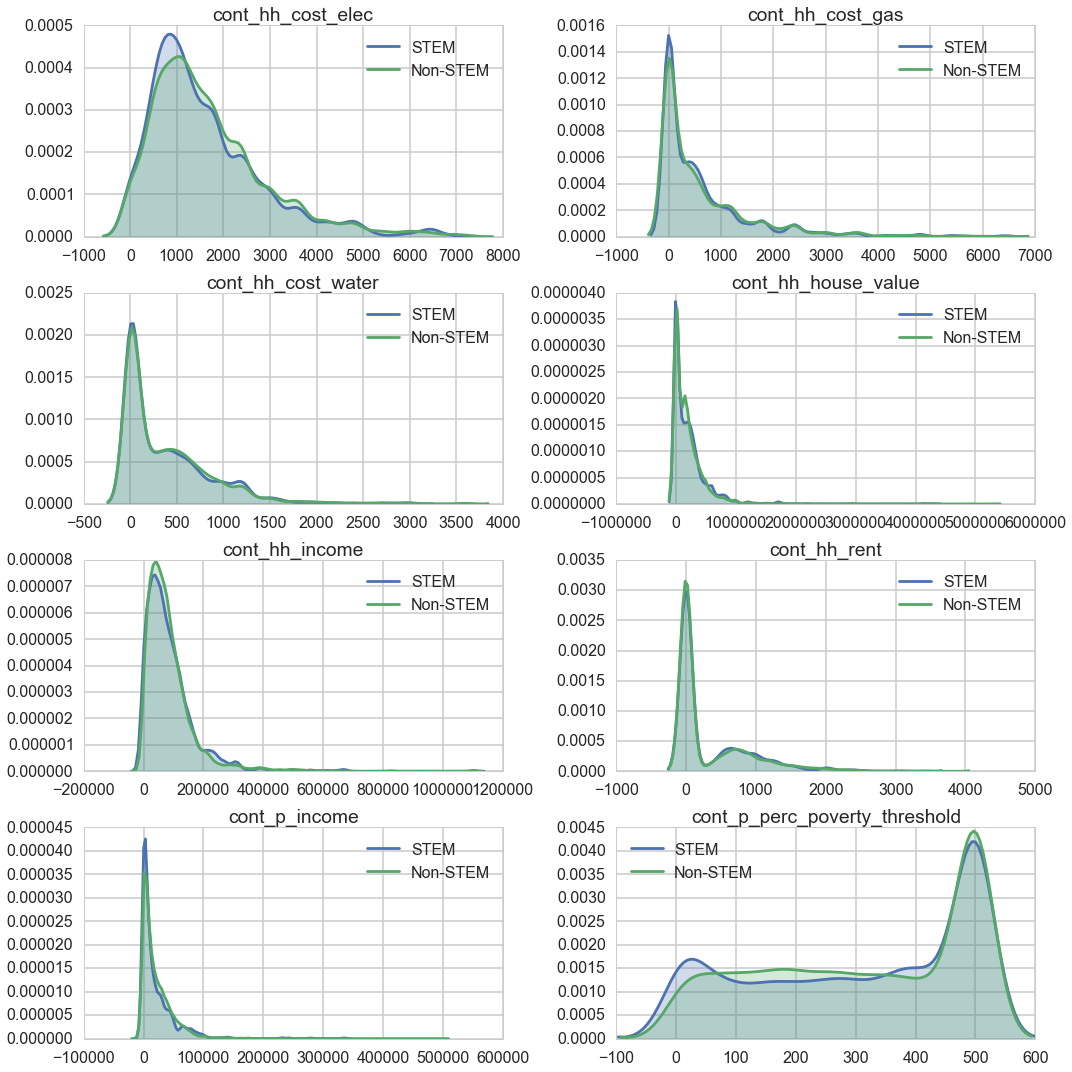

In [8]:
# check for trends in continuous variables
# note - not yet standardized
figContVars, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), tight_layout=True)

for axis, feature in zip(axes.ravel(), CONTINUOUS):
    sns.kdeplot(dftomodel[feature][dftomodel.i_p_stem==1], shade=True, label='STEM', ax=axis)
    sns.kdeplot(dftomodel[feature][dftomodel.i_p_stem==0], shade=True, label='Non-STEM', ax=axis)
    axis.set_title(feature)
    axis.legend(loc='best')

Some of these variables may be amenable to transformation, and this may be considered in future investigations. We will, however, standardize these variables below.

## creating training and test data sets

We standardize test and training sets separately. Specifically, we wish to standardize the non-indicator columns on both the test and training sets, by subtracting out the mean of the training set from the value, and dividing by the standard deviation of the training set. This helps us put all the continuous variables on the same scale.

In [9]:
from sklearn.cross_validation import train_test_split
# random_state sets the seed, for reproducibility
itrain, itest = train_test_split(xrange(dftomodel.shape[0]), train_size=0.7, random_state=123)

In [10]:
mask = np.ones(dftomodel.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask==1)

In [11]:
mask

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [12]:
mask.shape, mask.sum()

((13726,), 9608)

## standardization

We use the mask to compute the training and test parts of the dataframe. We use `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDARDIZABLE` on the training set. Then we use the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old non-standardized values in the `STANDARDIZABLE` columns of `dftomodel` by the new standardized ones.

In [13]:
from sklearn import preprocessing

# making a working copy, although not necessary (as we could use pandas slice commands)
# seems to be less buggy
working_df = dftomodel[STANDARDIZABLE].copy()
df_train = working_df[mask]
df_test = working_df[~mask]

std_scale = preprocessing.StandardScaler().fit(df_train)
train_std = std_scale.transform(df_train)
test_std = std_scale.transform(df_test)

working_df[mask] = train_std
working_df[~mask] = test_std

dftomodel[STANDARDIZABLE] = working_df

/Users/K-Lo/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [14]:
dftomodel.head()

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_college,i_p_college_degree,i_p_disability,i_p_employed,i_p_english_first,i_p_female,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_in_school,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings,tech_hh_id,tech_hh_weight,tech_p_dad_id,tech_p_id,tech_p_mom_id,tech_p_spouse_id,tech_p_weight
0,0.415855,-0.172717,0.417191,-0.479285,-0.715661,-0.592330,-0.561563,-0.946656,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0.747364,-0.352001,1.028274,0.598927,-1.025915,-0.248088,-1.041172,0.134110,1.228346,105,62,1,2,0,0,68
1,0.415855,-0.172717,-0.663030,1.063372,0.518666,-0.592330,-0.650386,1.067376,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0.747364,-0.352001,1.028274,0.598927,0.647882,0.590922,-0.960230,0.757492,1.228346,493,76,1,3,2,0,93
2,0.609845,-0.672978,-0.723042,-0.609964,-0.720323,-0.592330,-0.161863,-0.696324,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0.747364,-0.352001,-0.871660,0.598927,0.647882,-1.087097,0.982370,-0.489272,-0.391911,747,27,0,2,1,0,45
3,-1.330055,-0.672978,-0.783054,-0.657774,-0.114232,3.474797,-0.558147,1.067376,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,-0.014350,-0.352001,-0.871660,-1.075350,-1.025915,0.590922,1.063311,-0.489272,-0.391911,816,27,0,1,0,2,27
4,-0.554095,0.327544,0.417191,-0.294421,-0.497701,-0.592330,0.456477,-0.059116,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.014350,-0.352001,-0.871660,-1.075350,-1.025915,-0.248088,-0.393639,-0.489272,-0.391911,1607,21,0,2,0,1,24


## isolating predictors

We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. We also exclude features that are not in our `STANDARDIZABLE` or `INDICATORS` list. We count the number of features we have.

In [15]:
col_list = dftomodel.columns.tolist()
col_list

['cont_hh_cost_elec',
 'cont_hh_cost_gas',
 'cont_hh_cost_water',
 'cont_hh_house_value',
 'cont_hh_income',
 'cont_hh_rent',
 'cont_p_income',
 'cont_p_perc_poverty_threshold',
 'i_hh_college_degree',
 'i_hh_disability',
 'i_hh_employed',
 'i_hh_food_stamp',
 'i_hh_have_kids',
 'i_hh_health_insurance',
 'i_hh_immigrant',
 'i_hh_in_school',
 'i_hh_linguistic_isolation',
 'i_hh_married',
 'i_hh_mortgage',
 'i_hh_own_house',
 'i_hh_private_school',
 'i_hh_self_employed',
 'i_hh_speak_english',
 'i_hh_stem',
 'i_hh_stem_occupation',
 'i_hh_us_citizen',
 'i_hh_veteran',
 'i_p_born_usa',
 'i_p_college',
 'i_p_college_degree',
 'i_p_disability',
 'i_p_employed',
 'i_p_english_first',
 'i_p_female',
 'i_p_have_kids',
 'i_p_health_insurance',
 'i_p_immigrant',
 'i_p_in_school',
 'i_p_married',
 'i_p_private_school',
 'i_p_race_am_indian_alaska',
 'i_p_race_asian',
 'i_p_race_black',
 'i_p_race_hispanic',
 'i_p_race_other',
 'i_p_race_pacific_islander',
 'i_p_race_white',
 'i_p_self_employed',


In [16]:
# subtract STANDARDIZABLE, INDICATORS, and our response `i_p_stem`
extra_vars = list(set(col_list) - set(STANDARDIZABLE) - set(INDICATORS) - set(['i_p_stem']))
extra_vars

['tech_p_dad_id',
 'i_p_female',
 'tech_hh_weight',
 'tech_hh_id',
 'i_p_in_school',
 'tech_p_spouse_id',
 'i_p_college',
 'tech_p_mom_id',
 'i_p_college_degree',
 'tech_p_id',
 'tech_p_weight']

In [17]:
# drop these from the dataframe
dftomodel = dftomodel.drop(extra_vars, axis=1)
dftomodel

,cont_hh_cost_elec,cont_hh_cost_gas,cont_hh_cost_water,cont_hh_house_value,cont_hh_income,cont_hh_rent,cont_p_income,cont_p_perc_poverty_threshold,i_hh_college_degree,i_hh_disability,i_hh_employed,i_hh_food_stamp,i_hh_have_kids,i_hh_health_insurance,i_hh_immigrant,i_hh_in_school,i_hh_linguistic_isolation,i_hh_married,i_hh_mortgage,i_hh_own_house,i_hh_private_school,i_hh_self_employed,i_hh_speak_english,i_hh_stem,i_hh_stem_occupation,i_hh_us_citizen,i_hh_veteran,i_p_born_usa,i_p_disability,i_p_employed,i_p_english_first,i_p_have_kids,i_p_health_insurance,i_p_immigrant,i_p_married,i_p_private_school,i_p_race_am_indian_alaska,i_p_race_asian,i_p_race_black,i_p_race_hispanic,i_p_race_other,i_p_race_pacific_islander,i_p_race_white,i_p_self_employed,i_p_speak_english,i_p_stem,i_p_stem_occupation,i_p_us_citizen,i_p_veteran,int_hh_bedrooms,int_hh_num_families,int_hh_num_fathers,int_hh_num_generations,int_hh_num_mothers,int_hh_vehicles,int_p_age,int_p_family_size,int_p_num_siblings
0,0.415855,-0.172717,0.417191,-0.479285,-0.715661,-0.592330,-0.561563,-0.946656,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0.747364,-0.352001,1.028274,0.598927,-1.025915,-0.248088,-1.041172,0.134110,1.228346
1,0.415855,-0.172717,-0.663030,1.063372,0.518666,-0.592330,-0.650386,1.067376,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0.747364,-0.352001,1.028274,0.598927,0.647882,0.590922,-0.960230,0.757492,1.228346
2,0.609845,-0.672978,-0.723042,-0.609964,-0.720323,-0.592330,-0.161863,-0.696324,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0.747364,-0.352001,-0.871660,0.598927,0.647882,-1.087097,0.982370,-0.489272,-0.391911
3,-1.330055,-0.672978,-0.783054,-0.657774,-0.114232,3.474797,-0.558147,1.067376,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,-0.014350,-0.352001,-0.871660,-1.075350,-1.025915,0.590922,1.063311,-0.489272,-0.391911
4,-0.554095,0.327544,0.417191,-0.294421,-0.497701,-0.592330,0.456477,-0.059116,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.014350,-0.352001,-0.871660,-1.075350,-1.025915,-0.248088,-0.393639,-0.489272,-0.391911
5,1.094820,-0.547913,2.417600,-0.211551,-0.128219,-0.592330,-0.189193,0.105875,0,0,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.014350,-0.352001,1.028274,0.598927,0.647882,1.429932,-0.960230,0.757492,1.228346
6,0.221865,-0.672978,-0.723042,-0.657774,-0.921965,-0.592330,-0.465909,-1.623689,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.014350,-0.352001,1.028274,0.598927,0.647882,0.590922,-0.879289,1.380874,-0.391911
7,1.482799,1.203001,-0.723042,-0.609964,-0.881170,-0.592330,-0.346340,-1.367668,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.014350,0.918005,-0.871660,0.598927,0.647882,-0.248088,-0.312697,-0.489272,-0.391911
8,0.609845,-0.672978,0.777265,-0.657774,-0.807740,0.757216,-0.131117,-1.128715,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0.747364,-0.352001,-0.871660,0.598927,0.647882,-1.087097,1.306136,-0.489272,-0.391911
9,-0.263110,-0.672978,-0.723042,-0.243424,-0.473225,-0.592330,-0.722127,-0.292380,1,0,1,0,1,1,0,1,0,1,1,1,1,0,1,0,0,1,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.014350,-0.352001,1.028274,0.598927,0.647882,-0.248088,-0.393639,0.134110,-0.391911


<div class="alert alert-info">
We define the response variable as "RESP" here.
</div>

In [18]:
RESP = "i_p_stem"  

## list of predictor variables
lcols = list(dftomodel.columns)
lcols.remove(RESP)
assert len(lcols)==len(STANDARDIZABLE+INDICATORS)
print len(lcols)

57


## cross-validation

We provide a function `cv_optimize`, which uses a Grid Search in parameters, and a default of 5-fold cross-validation. It takes as arguments a classifier `clf`, with hyper-parameter dictionary `parameters`, training feature matrix `X`, response `y`, number of folds `n_folds`, and custom scoring function `score_func`. It performs cross-validation using `GridSearchCV` along with a grid-search of hyperparameters. It obtains the best model by the average cross-validation score (allowing for a custom cross-validation score, not just those provided by `sklearn`), and finally returns this best model. <br><p>

This `cv_optimize` function will be passed to the subsequent `do_classify` function.

In [19]:
from sklearn.grid_search import GridSearchCV

"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary that is passed to GridSearchCV
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""

def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    
    return best

We use the `cv_optimize` function to implement the function `do_classify` below, which provides a general interface to any classifier. This function `do_classify` can take either a mask or a `reuse_split` dictionary to specify which is the training set and which is the test set in X and y. In the former case the mask is used to choose which samples to use as training samples and which ones to use as test samples. In the latter case a dictionary is used to directly provide training and test sets. This is useful when the splits have already been done and we want to test multiple classifiers on the same test set to compare their performance. <br><p>

We construct the features from `featurenames` columns of the dataframe `indf`, while the column name `targetname` is used with `target1val` as the value that provides a 1 (i.e. a positive instance). A custom scorer can be provided in the optional `score_func` argument (with default value None). `n_folds` is the number of cross-validation folds, set to a default value of 5. <br><p>

This function prints out the accuracy score on the training and test data, and also the confusion matrix associated with this classifier. It returns the best_fit classifier, along with the training and test sets. Note that the parameters dictionary is used to provide a parameter dictionary in the style of GridSearchCV, which is used by the function `cv_optimize` above.

In [20]:
from sklearn.metrics import confusion_matrix

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, 
                mask=None, reuse_split=None, score_func=None, n_folds=5):
    
    subdf = indf[featurenames]
    X = subdf.values
    y = (indf[targetname].values==target1val)*1
    
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest = reuse_split['Xtrain'], reuse_split['Xtest']
        ytrain, ytest = reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, 
                             score_func=score_func)
    clf = clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    
    return clf, Xtrain, ytrain, Xtest, ytest

## looking at the response variable

In [21]:
# individuals are only college women
# whether the individual is in a STEM major or not

print "whole data set", dftomodel[RESP].mean()
print "training set", dftomodel[RESP][mask].mean(), "test set", dftomodel[RESP][~mask].mean()

whole data set 0.5
training set 0.501457119067 test set 0.496600291404


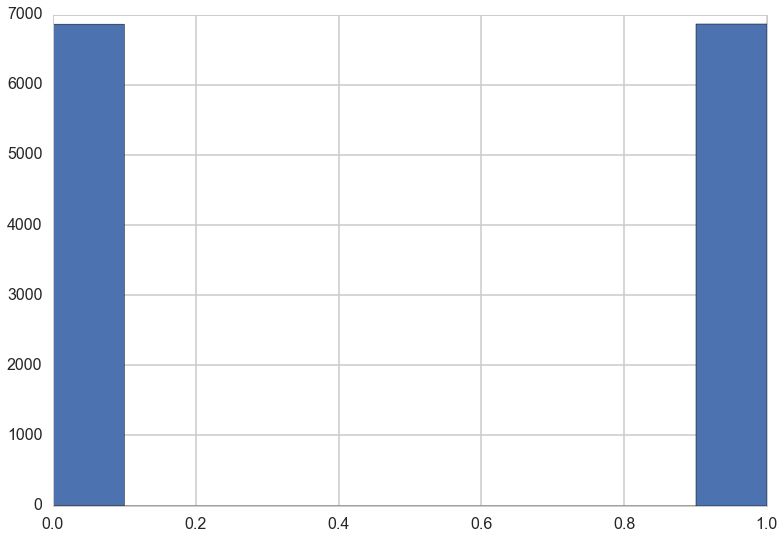

In [22]:
plt.hist(dftomodel[RESP]);

This makes sense as we rebalanced the classes in the data preparation phase.

----

# modeling

## logistic regression with Lasso based feature selection

We proceed with a Logistic regression model with Lasso penalty, a form of <i>regularization</i> and variable selection. We can think of regularization as adding a penalty term to a cost function to encourage smaller weights; or, in other words, to penalize large weights. Mathematically, Logistic regression with Lasso minimizes the equation:

$$
\min_{(\beta_0, \beta) \in \mathbb{R}^{p+1}} -\left[\frac{1}{N} \sum_{i=1}^N y_i \cdot (\beta_0 + x_i^T \beta) - \log (1+e^{(\beta_0+x_i^T \beta)})\right] + \alpha\ ||\beta||_1
$$

We are essentially looking for solutions $(\beta_0, \beta)$ that are **small** in terms of the $L_1$ norm.<br><p>

To run a <i>logistic regression with L1 regularization</i>, we use the `do_classify` function defined above. L1 or <b>Lasso</b> regularization automatically does feature selection for us. <br><p>

We return as the estimator `clflog`, and training and test sets `Xtrain`, `ytrain`, `Xtest`, and `ytest`. We let the regularization hyperparameter `C` range in powers of 10 from 0.0001 to 100,000. To use "L1" or Lasso regularization, we pass penalty="l1" to `LogisticRegression`: `clf = LogisticRegression(penalty="l1")`.

<div class="alert alert-info">
<b>Model 1</b> - female college students, all ages
</div>

In [23]:
from sklearn.linear_model import LogisticRegression

#random_state sets a fixed seed for reproducibility
clflog = LogisticRegression(penalty="l1", random_state=234)

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clflog, parameters, dftomodel, lcols, 
                                                   RESP, 1, mask=mask)

reuse_split = dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)  # save for reuse

using mask
BEST {'C': 1} 0.604600333056 [mean: 0.49854, std: 0.00013, params: {'C': 0.0001}, mean: 0.49854, std: 0.00013, params: {'C': 0.001}, mean: 0.59981, std: 0.01725, params: {'C': 0.01}, mean: 0.60398, std: 0.02757, params: {'C': 0.1}, mean: 0.60460, std: 0.02465, params: {'C': 1}, mean: 0.60418, std: 0.02478, params: {'C': 10}, mean: 0.60439, std: 0.02513, params: {'C': 100}, mean: 0.60439, std: 0.02513, params: {'C': 1000}, mean: 0.60439, std: 0.02513, params: {'C': 10000}, mean: 0.60439, std: 0.02513, params: {'C': 100000}]
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.61
[[1387  686]
 [ 904 1141]]
########################################################


/Users/K-Lo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


It does not seem to have a very high degree of accuracy, but it is not too bad, and at least it is not overfitting. But note:

In [24]:
np.mean(dftomodel[RESP])

0.5

... we are still doing quite a bit better than random guessing.

### regularization path

Let's <b>plot the regularization path</b>, which is the weight coefficients of the different features for different regularization strengths:

In [25]:
print len(clflog.coef_[0])

57


In [26]:
clflog

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=234, solver='liblinear', tol=0.0001,
          verbose=0)

In [27]:
# dataframe of coefficients from logistic regression model obtained from CV at best "C"
coefdf = pd.DataFrame({
        'features': lcols,
        'female_coeffs': clflog.coef_[0]
        })
coefdf

,features,female_coeffs
0,cont_hh_cost_elec,-0.022439
1,cont_hh_cost_gas,-0.002007
2,cont_hh_cost_water,-0.051041
3,cont_hh_house_value,-0.066562
4,cont_hh_income,0.026975
5,cont_hh_rent,-0.103983
6,cont_p_income,-0.000291
7,cont_p_perc_poverty_threshold,-0.065639
8,i_hh_college_degree,0.072353
9,i_hh_disability,-0.270402


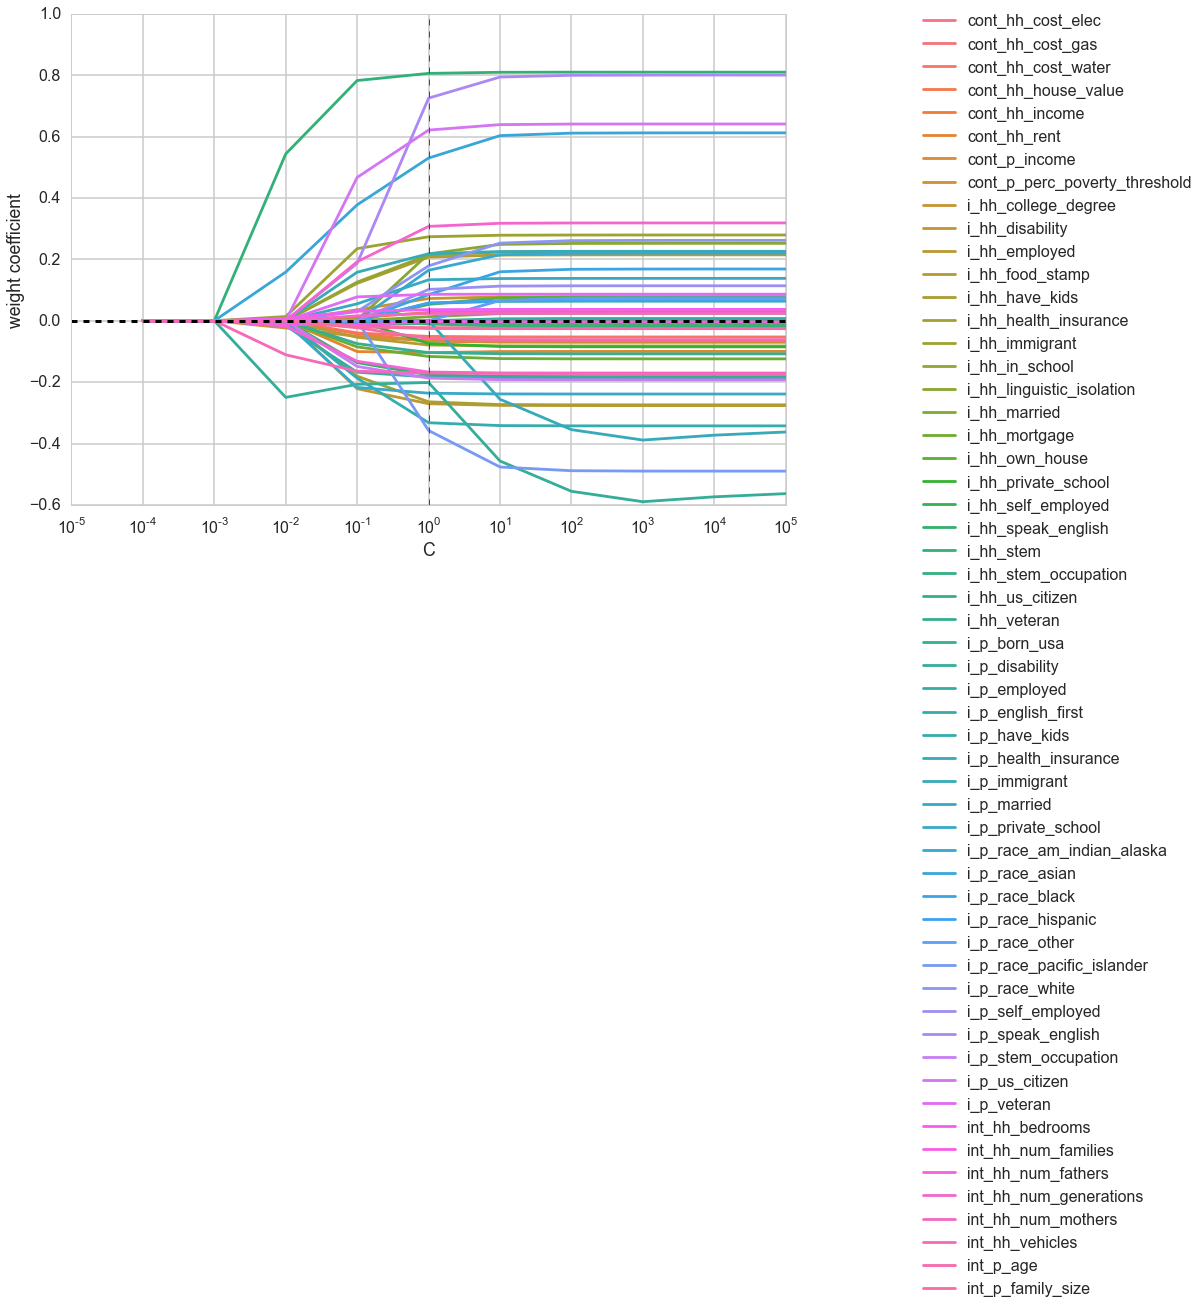

In [28]:
# Adapted from 
# Source: S. Raschka, "Python Machine Learning" (2015)

fig = plt.figure()
ax = plt.subplot(111)
colors = sns.color_palette(palette="husl", n_colors=(len(clflog.coef_[0])+1))
weights, params = [], []

for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=234)
    lr.fit(Xtrain, ytrain)
    # print lr.coef_  # for debugging
    weights.append(lr.coef_[0])  # only two classes
    params.append(10**c)

weights = np.array(weights)

# power of C for best "C"
best_c = 0 # fourth index is C = 1

for column, color in zip(range(weights.shape[1]), colors):
    if dftomodel.columns[column]!=RESP:
        x = params
        y = weights[:, column]
        plt.plot(x, y,
                 label=dftomodel.columns[column],
                 color=color)

plt.axvline(10**(-(best_c)), color="red", linestyle="--", linewidth=1) # added reference line
plt.axhline(0, color="black", linestyle="--", linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

We noticed that a number of the coefficients were zeroed when applying the Lasso penalty, which included *i_hh_self_employed*, *i_p_english_first*, *i_p_immigrant*, and *i_p_race_other*. This does not necessarily mean these variables are unimportant when considered in isolation; it is possible that many of these variables are strongly correlated with others, and relatively speaking, these particular features are not sufficiently increasing the degree of accuracy in the model with their inclusion.

As for the other features remaining in the model, some appear to have very little relative effect on the response, while others would seem to be more important due to their larger magnitudes. We sorted the coefficients by magnitude and sign, and depicted them graphically below -- the greatest positive coefficients would appear to have the greatest positive effect, while the greatest negative coefficients would appear to have the greatest negative effect:

![](images/logreg1.png)

![](images/logreg2.png)

![](images/infopic.jpg)

We highlight the top 5 factors based on the coefficients of the model (the top 5 positive factors are also the top 5 in magnitude):

* <b>individual works in a STEM occupation (this may mean they have part-time work, or they had full-time work and are studying part-time)</b> -- this makes sense as these individuals likely already have an affinity toward STEM majors
* <b>another member of the household studied STEM in college</b> -- this is eye-opening, and may speak to the importance of having good role models in the family, and possibly strong mentors on a broader level when younger
* <b>the individual speaks English</b> (note this just suggests an association, it is not causation)
* <b>veteran status</b> -- perhaps science and engineering skills are more valued for individuals trained or training for military service
* <b>asian descent</b> -- there may be cultural influences at play

It is also interesting to take note of the five factors that have a strong negative association, including factors such as having children, or a disability. 

### interpretation of coefficients

The sign of each coefficient indicates whether the probability that an individual will be classified as a STEM (RESP=1) increases or decreases as the value of the predictor increases. The estimated *odds* of a "success" (that the individual is classified as STEM) change by a **multiplicative factor of** *exp(coefficient)* for a one-unit increase in the predictor (for a continuous variable after standardization), or when the value of an indicator is 1 rather than zero, *holding all other predictors constant*. 

## ROC curves

In anticipation of model comparison, we provide code in `make_roc` to plot ROC curves. <br><p>

ROC curves are a set of classifiers, many of them, each point corresponding to a different threshold. They are useful to compare classifiers to each other and also to baseline models.
In the standard scenario, where we use classifier accuracy, this threshold is implicitly set at 0.5, and this corresponds to only one point on the ROC curve. <br><p>

To calculate a ROC curve, we pass `proba=False` to `make_roc` for non-probabilistic classifiers (e.g. SVM). Here, we can leave this as True for logistic regression. This function uses `roc_curve` from <i>sklearn</i>: note that this function carries out the process we described and gives us back a triplet of `fpr`, `tpr`, and `thresholds`. We also calculate the auc, and plot the roc curve with thresholds, skipping every `labe` number of thresholds to make labels.

In [29]:
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba: # for classifiers like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else: # for classifiers like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, 
                label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, 
                label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

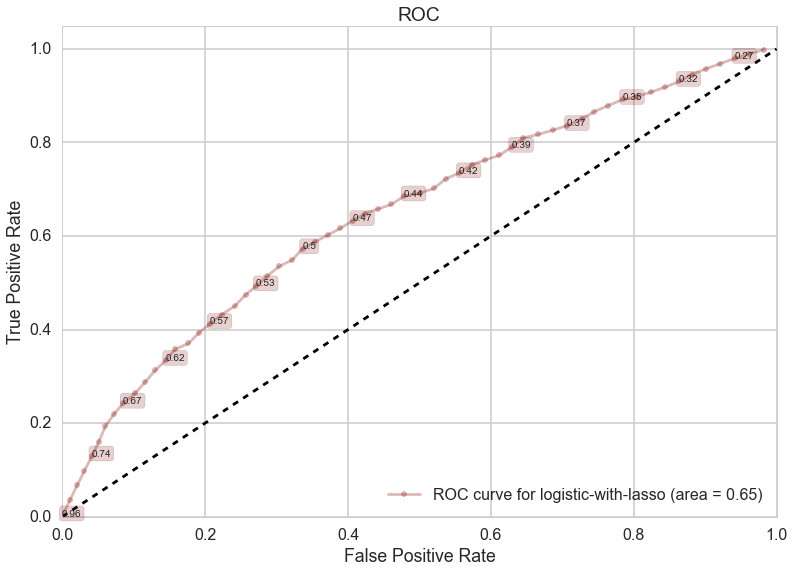

In [30]:
# for the first plot we do not pass an axes object. Subsequent calls to
# make_roc can use the returned axes object ax.
with sns.hls_palette(2, l=.3, s=.8):
    make_roc("logistic-with-lasso", clflog, ytest, Xtest, labe=200, skip=50)

Note that the threshold value of 0.5 for the original logistic-with-lasso model seems nearest the upper left corner on the curve. This is not too surprising giving that we pre-balanced the dataset. <br><p>

We incorporate some interactivity.

In [31]:
z1 = np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    with sns.hls_palette(2, l=.3, s=.8):
        make_roc("logistic-with-lasso", clflog, ytest, Xtest, labe=200, skip=50)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

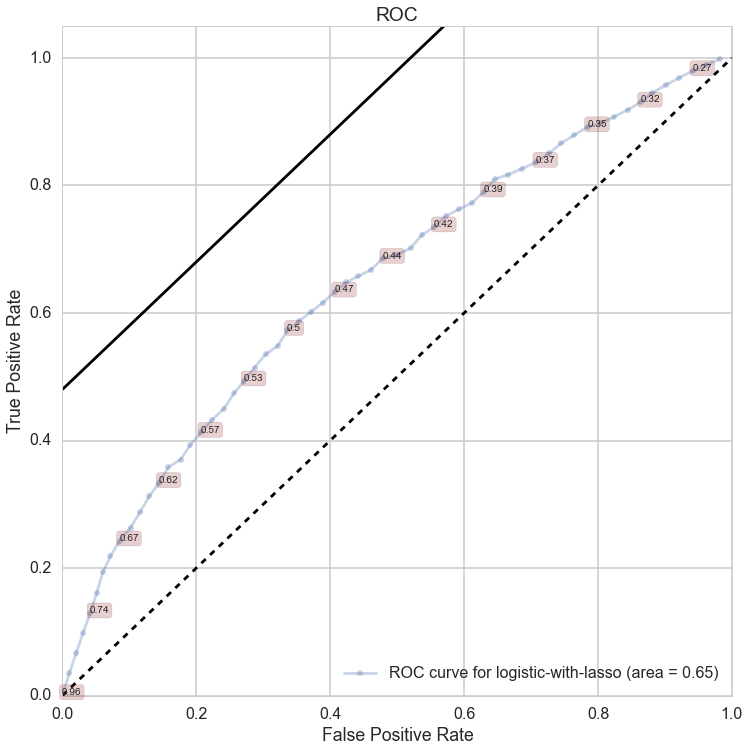

In [32]:
slope = 1

# this "new" package when run in an Jupyter Notebook is still a bit buggy
# it is a documented issue, and a new instance of notebook may need to be re-run
from ipywidgets import interact, fixed
interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.02));

## elastic net regularized logistic regression

This is a combination of Lasso and Ridge regularization. 

>$$
\begin{aligned}
\log = \frac{\text{Pr}(V=1|X=x)}{\text{Pr}(V=0|X=x)} = \beta_0 + \beta^T x
\end{aligned}
$$

>Thus, the objective function is to minimize 
>
$$
\begin{aligned}
\min_{(\beta_0, \beta) \in \mathbb{R}^{p+1}} -\left[\frac{1}{N} \sum_{i=1}^N y_i \cdot (\beta_0 + x_i^T \beta) - \log (1+e^{(\beta_0+x_i^T \beta)})\right] + \alpha (1-\lambda)||\beta||_2^2/2 + \alpha\lambda||\beta||_1
\end{aligned}
$$

In our code $\lambda =$ `l1_ratio`, and an $\alpha$ range is determined by `eps`, see the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) for more details. 

According to Hui Zou and Trevor Hastie, <i>Regularization and Variable Selection via the Elastic Net</i>:
    
Here are some limitations of Lasso regularization that Elastic Net is supposed to address:

* If p > n, the lasso selects at most n variables.
* Grouped variables: the lasso fails to do grouped selection. It tends to select one variable from a group and ignore the others.

In [33]:
from sklearn.linear_model import lasso_path, enet_path
eps = 5e-6  # the smaller it is the longer is the path

df_noresp = dftomodel.drop(RESP, axis=1)
mm = pd.DataFrame(Xtrain, columns=df_noresp.columns)
X = Xtrain.astype(np.double)
Y = ytrain.astype(np.double)

In [34]:
%%time
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, Y, eps, fit_intercept=False)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X, Y, eps=eps, l1_ratio=0.8, 
                                       fit_intercept=False)

Computing regularization path using the lasso...
Computing regularization path using the elastic net...
CPU times: user 71.8 ms, sys: 3.73 ms, total: 75.5 ms
Wall time: 82.3 ms


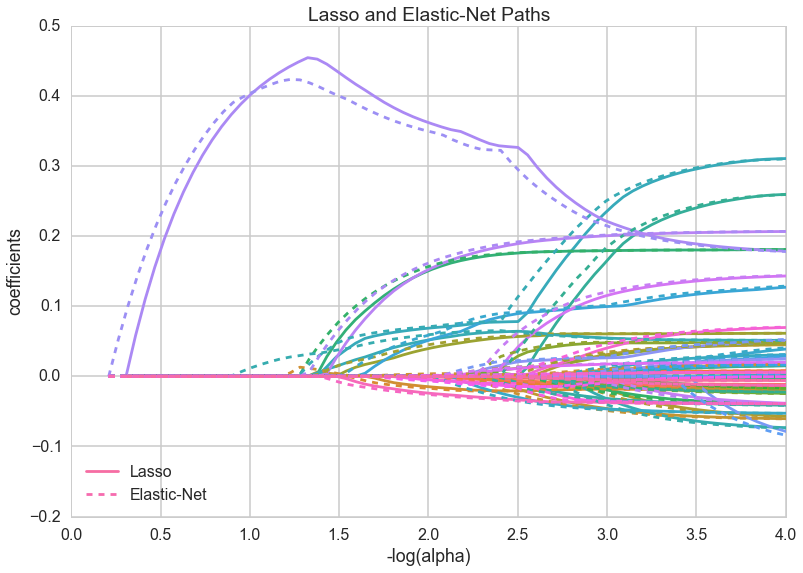

In [35]:
# Color Palette, seaborn has the best colors i.m.o.
col = sns.color_palette("husl", 58)

# make the lasso path
plt.figure(1)
ax = plt.gca()
ax.set_color_cycle(col)
l1 = plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
l2 = plt.plot(-np.log10(alphas_enet), coefs_enet.T, linestyle='--')
plt.xlim([0, 4])

plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left');

In [36]:
# subset variables with large coefficients
# selected somewhat arbitrarily, could do something better here.

# show all coefficients
# keep = np.ones(keep.sum(), dtype=bool)
# show only if sum of coefficients larger than something
keep = np.abs(coefs_enet.T.sum(axis = 0)) > 7
# show only if least shrunk coefficient larger than something
# keep = np.abs(coefs_enet.T[99,:]) > 0.08  # arbitrary

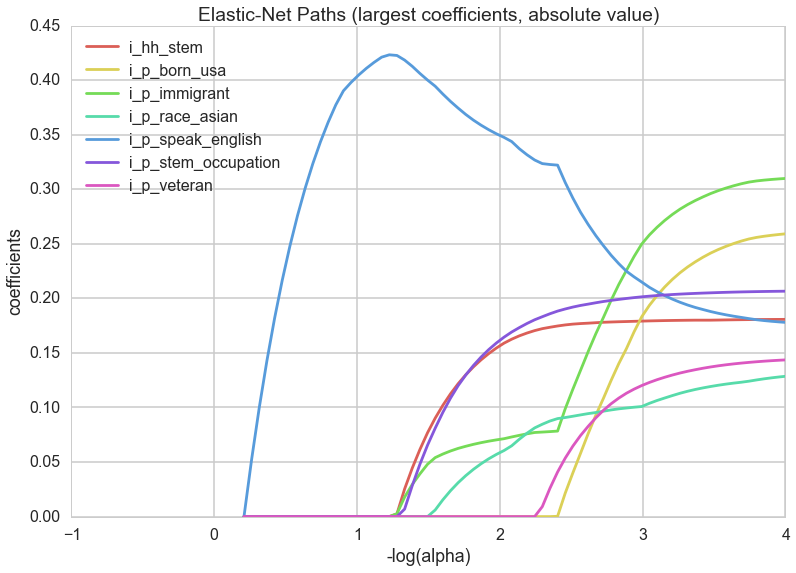

In [37]:
# Color Palette, seaborn has the best colors i.m.o.
col = sns.color_palette("hls", keep.sum())

plt.figure(1)
ax = plt.gca()
ax.set_color_cycle(col)
l2 = plt.plot(-np.log10(alphas_enet), coefs_enet.T[:,keep])
plt.xlim([-1, 4])

plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net Paths (largest coefficients, absolute value)')
plt.legend(l2, list(mm.columns.values[keep]), loc='upper left');

The lasso curve does not seem to misbehave and the adjustment associated with the Elastic-Net model tracks it quite closely. Indeed, the top results are similar to what we derived from the plot made earlier (i.e. suggestions of which features matter most). It seems like we can stick with our logistic regression model.

Each method relies on logistic regression with a different technique for selecting features. One of the reasons feature selection is done, automatically or otherwise, is that there might be strong correlations between features. A large number of features can also lead to overfitting. Feature selection helps curb the problem of the curse of dimensionality.

----

## feature selection using linear discriminant analysis

The goal in Linear Discriminant Analysis (LDA) is to find the feature subspace that optimizes class separability. Both LDA and Principal Component Analysis (PCA) are linear transformation techniques that can be used to reduce the number of dimensions in a dataset; LDA is supervised whereas PCA is unsupervised. <br><p>

For LDA, it is assumed the data is normally distributed, and that features are statistically independent. Nevertheless, LDA can often work reasonably well despite violations of these assumptions.

In [38]:
# Credit:
# Sebastian Raschka 08/13/2014
# mlxtend Machine Learning Library Extensions
# matplotlib utilities for removing chartchunk

from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, clf, X_highlight=None, res=0.02, cycle_marker=True, legend=1, cmap=None):
    """
    Plots decision regions of a classifier.
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
      Feature Matrix.
    y : array-like, shape = [n_samples]
      True class labels.
    clf : Classifier object. Must have a .predict method.
    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
      An array with data points that are used to highlight samples in `X`.
    res : float (default: 0.02)
      Grid width. Lower values increase the resolution but
      slow down the plotting.
    cycle_marker : bool
      Use different marker for each class.
    legend : int
      Integer to specify the legend location.
      No legend if legend is 0.
    cmap : Custom colormap object .
    Returns
    ---------
    None
    Examples
    --------
    from sklearn import datasets
    from sklearn.svm import SVC
    iris = datasets.load_iris()
    X = iris.data[:, [0,2]]
    y = iris.target
    svm = SVC(C=1.0, kernel='linear')
    svm.fit(X,y)
    plot_decision_region(X, y, clf=svm, res=0.02, cycle_marker=True, legend=1)
    plt.xlabel('sepal length [cm]')
    plt.ylabel('petal length [cm]')
    plt.title('SVM on Iris')
    plt.show()
    """
    # check if data is numpy array
    for a in (X, y):
        if not isinstance(a, np.ndarray):
            raise ValueError('%s must be a NumPy array.' % a.__name__)

    # check if test data is provided
    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_test must be a NumPy array or None')
        else:
            plot_testdata = False

    if len(X.shape) == 2 and X.shape[1] > 1:
        dim = '2d'
    else:
        dim = '1d'


    marker_gen = cycle('sxo^v')

    # make color map
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    n_classes = len(np.unique(y))
    if n_classes > 5:
        raise NotImplementedError('Does not support more than 5 classes.')

    if not cmap:
        cmap = matplotlib.colors.ListedColormap(colors[:n_classes])

    # plot the decision surface

    if dim == '2d':
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    else:
        y_min, y_max = -1, 1

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, res),
                         np.arange(y_min, y_max, res))

    if dim == '2d':
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    else:
        y_min, y_max = -1, 1
        Z = clf.predict(np.array([xx.ravel()]).T)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # plot class samples

    for c in np.unique(y):
        if dim == '2d':
            y_data = X[y==c, 1]
        else:
            y_data = [0 for i in X[y==c]]

        plt.scatter(x=X[y==c, 0],
                    y=y_data,
                    alpha=0.8,
                    c=cmap(c),
                    marker=next(marker_gen),
                    label=c)

    if legend:
        plt.legend(loc=legend, fancybox=True, framealpha=0.5)

    if plot_testdata:
        if dim == '2d':
            plt.scatter(X_highlight[:,0], X_highlight[:,1], c='', alpha=1.0, linewidth=1, marker='o', s=80)
        else:
            plt.scatter(X_highlight, [0 for i in X_highlight], c='', alpha=1.0, linewidth=1, marker='o', s=80)


/Users/K-Lo/anaconda/lib/python2.7/site-packages/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


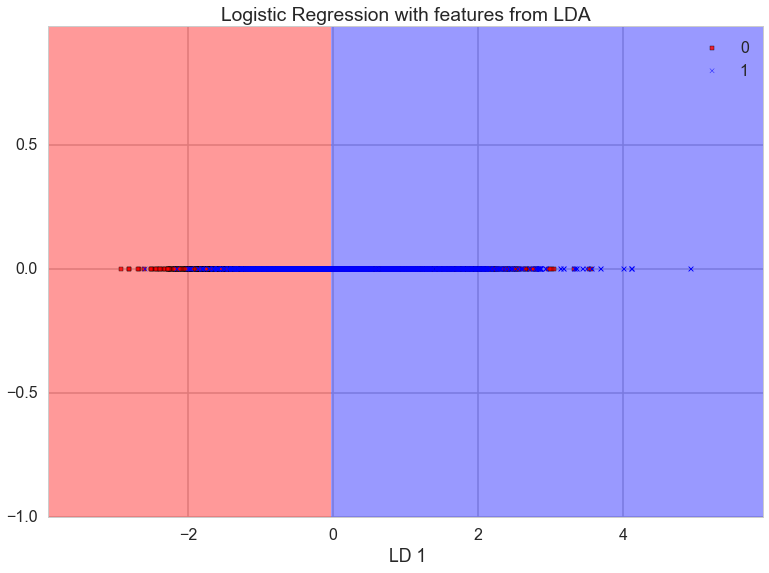

In [39]:
from sklearn.lda import LDA
lda = LDA(n_components=2)
X_train_lda_fit = lda.fit(Xtrain, ytrain)
X_train_lda = X_train_lda_fit.transform(Xtrain)

clflog2 = LogisticRegression()
clflog2 = clflog2.fit(X_train_lda, ytrain)
plot_decision_regions(X_train_lda, ytrain, clf=clflog2, res=0.02, cycle_marker=True, legend=1)
plt.xlabel("LD 1")
plt.ylabel("")
plt.title('Logistic Regression with features from LDA')
plt.show()

In [40]:
training_accuracy = clflog2.score(X_train_lda, ytrain)
training_accuracy

0.63124479600333061

In [41]:
Xtest_LDA = X_train_lda_fit.transform(Xtest)
test_accuracy = clflog2.score(Xtest_LDA, ytest)

print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clflog2.predict(Xtest_LDA))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.62
[[1380  693]
 [ 886 1159]]
########################################################


This model has comparable accuracy, but the results are not as readily interpretable as the Logistic Regression model.

----

# subgroup analysis

We also decided to take a closer look at certain natural divisions between various groups of individuals, to see whether the model, and more particularly the most influential factors based on the coefficients of a logistic regression model would be different as between these groups.

## male college students

In [42]:
dftomodel_male = pd.read_csv('dftomodel_maleall.csv')
dftomodel_male.drop('Unnamed: 0', axis=1, inplace=True)

In [43]:
# build training and test sets
itrain, itest = train_test_split(xrange(dftomodel_male.shape[0]), train_size=0.7, random_state=456)
mask = np.ones(dftomodel_male.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask==1)

In [44]:
# standardize predictors
working_df = dftomodel_male[STANDARDIZABLE].copy()
df_train = working_df[mask]
df_test = working_df[~mask]

std_scale = preprocessing.StandardScaler().fit(df_train)
train_std = std_scale.transform(df_train)
test_std = std_scale.transform(df_test)

working_df[mask] = train_std
working_df[~mask] = test_std

dftomodel_male[STANDARDIZABLE] = working_df

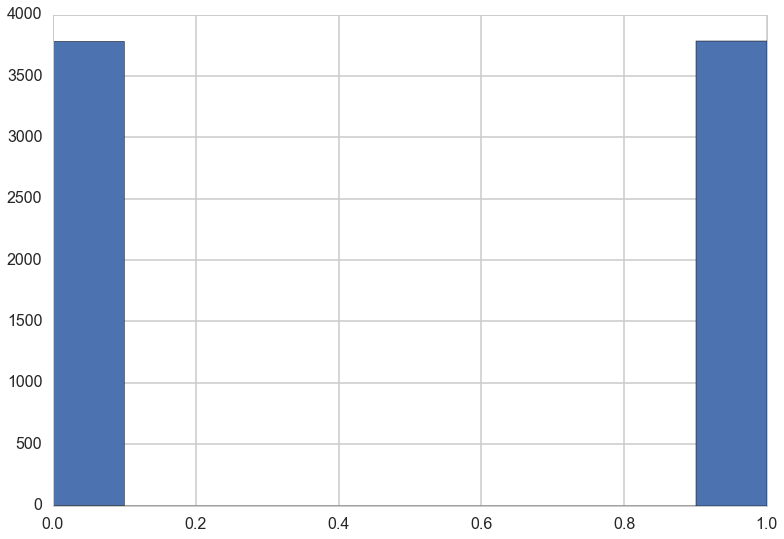

In [45]:
# drop extra variables, and look at response variable to check if balanced
dftomodel_male = dftomodel_male.drop(extra_vars, axis=1)
plt.hist(dftomodel_male[RESP]);

In [46]:
# fit logistic regression model
clflog_male = LogisticRegression(penalty="l1", random_state=345)

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clflog_male, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_male, parameters, 
                                                        dftomodel_male, lcols,
                                                        RESP, 1, mask=mask)

using mask
BEST {'C': 0.1} 0.625165312677 [mean: 0.49726, std: 0.00019, params: {'C': 0.0001}, mean: 0.49726, std: 0.00019, params: {'C': 0.001}, mean: 0.60665, std: 0.00877, params: {'C': 0.01}, mean: 0.62517, std: 0.02790, params: {'C': 0.1}, mean: 0.62460, std: 0.03069, params: {'C': 1}, mean: 0.62271, std: 0.03019, params: {'C': 10}, mean: 0.62158, std: 0.02965, params: {'C': 100}, mean: 0.62120, std: 0.02985, params: {'C': 1000}, mean: 0.62120, std: 0.02985, params: {'C': 10000}, mean: 0.62120, std: 0.02985, params: {'C': 100000}]
############# based on standard predict ################
Accuracy on training data: 0.65
Accuracy on test data:     0.64
[[877 272]
 [541 579]]
########################################################


/Users/K-Lo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [47]:
# save dataframe of coefficients from logistic regression model obtained from CV at best "C"
coefdf_male = pd.DataFrame({
        'features': lcols,
        'male_coeffs': clflog_male.coef_[0]
        })
coefdf_male

,features,male_coeffs
0,cont_hh_cost_elec,-0.035629
1,cont_hh_cost_gas,0.012633
2,cont_hh_cost_water,0.034339
3,cont_hh_house_value,-0.021981
4,cont_hh_income,-0.055102
5,cont_hh_rent,0.000000
6,cont_p_income,0.000000
7,cont_p_perc_poverty_threshold,0.000573
8,i_hh_college_degree,-0.070619
9,i_hh_disability,-0.070603


In [48]:
# sort by coefficient
sortedcoef_male = coefdf_male.sort(coefdf_male.columns[1], ascending=False)
sortedcoef_male

,features,male_coeffs
45,i_p_stem_occupation,1.395930
23,i_hh_stem,0.499793
16,i_hh_linguistic_isolation,0.245377
14,i_hh_immigrant,0.187013
24,i_hh_stem_occupation,0.179835
33,i_p_immigrant,0.177854
39,i_p_race_hispanic,0.147613
37,i_p_race_asian,0.130584
12,i_hh_have_kids,0.055021
48,int_hh_bedrooms,0.051046


With respect to top positive factors, being in a STEM occupation and having a household member study a STEM major in college are also strong indicators; having a household member work in a STEM occupation appears to have higher influence here, and having a household member be an immigrant to the U.S. as well as being positive for "linguistic isolation" (all members 14 years old and over have at least some difficulty with English) are also influential. This might suggest that as far as males are concerned, being from an immigrant family can be associated with a higher probability that the male student will study in a STEM major in college.

With respect to top negative factors, it is interesting to note that being in private school again appears in the top five (perhaps they more likely go into a social science like law, business, or economics?). 

## older female college students

We arbitrarily chose 25 as the threshold; "older" female college students are aged 25 and older.

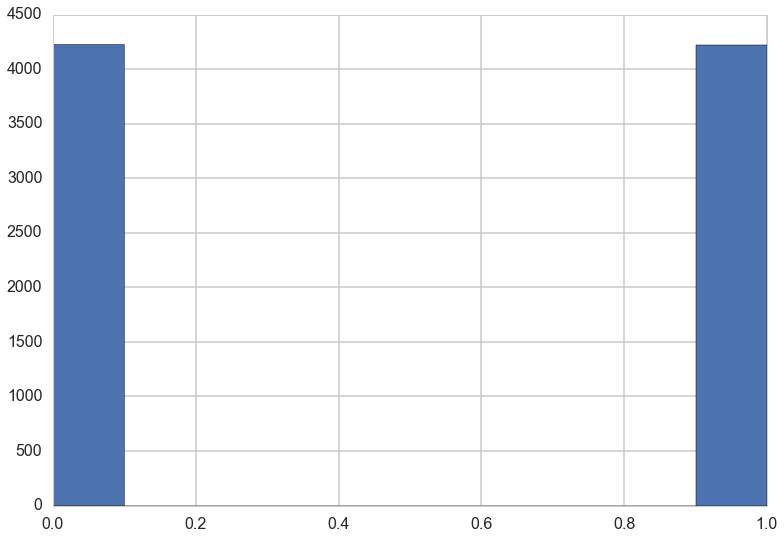

In [49]:
dftomodel_oldf = pd.read_csv('dftomodel_femaleover25.csv')
dftomodel_oldf.drop('Unnamed: 0', axis=1, inplace=True)

# build training and test sets
itrain, itest = train_test_split(xrange(dftomodel_oldf.shape[0]), train_size=0.7, 
                                 random_state=555)
mask = np.ones(dftomodel_oldf.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask==1)

# standardize predictors
working_df = dftomodel_oldf[STANDARDIZABLE].copy()
df_train = working_df[mask]
df_test = working_df[~mask]

std_scale = preprocessing.StandardScaler().fit(df_train)
train_std = std_scale.transform(df_train)
test_std = std_scale.transform(df_test)

working_df[mask] = train_std
working_df[~mask] = test_std

dftomodel_oldf[STANDARDIZABLE] = working_df

# drop extra variables, and look at response variable to check if balanced
dftomodel_oldf = dftomodel_oldf.drop(extra_vars, axis=1)
plt.hist(dftomodel_oldf[RESP]);

In [50]:
# fit logistic regression model
clflog_oldf = LogisticRegression(penalty="l1", random_state=543)

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clflog_oldf, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_oldf, parameters, 
                                                        dftomodel_oldf, lcols,
                                                        RESP, 1, mask=mask)

using mask
BEST {'C': 0.1} 0.627557058326 [mean: 0.50854, std: 0.00017, params: {'C': 0.0001}, mean: 0.50854, std: 0.00017, params: {'C': 0.001}, mean: 0.62249, std: 0.01813, params: {'C': 0.01}, mean: 0.62756, std: 0.02920, params: {'C': 0.1}, mean: 0.62384, std: 0.03578, params: {'C': 1}, mean: 0.62232, std: 0.03610, params: {'C': 10}, mean: 0.62198, std: 0.03595, params: {'C': 100}, mean: 0.62198, std: 0.03595, params: {'C': 1000}, mean: 0.62198, std: 0.03595, params: {'C': 10000}, mean: 0.62198, std: 0.03595, params: {'C': 100000}]
############# based on standard predict ################
Accuracy on training data: 0.65
Accuracy on test data:     0.62
[[859 358]
 [595 723]]
########################################################


/Users/K-Lo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [51]:
# save dataframe of coefficients from logistic regression model obtained from CV at best "C"
coefdf_oldf = pd.DataFrame({
        'features': lcols,
        'olderfemale_coeffs': clflog_oldf.coef_[0]
        })

# sort by coefficient
sortedcoef_oldf = coefdf_oldf.sort(coefdf_oldf.columns[1], ascending=False)
sortedcoef_oldf

,features,olderfemale_coeffs
23,i_hh_stem,0.959826
45,i_p_stem_occupation,0.874095
47,i_p_veteran,0.368248
37,i_p_race_asian,0.201701
11,i_hh_food_stamp,0.201503
34,i_p_married,0.198186
43,i_p_self_employed,0.160573
52,int_hh_num_mothers,0.139137
14,i_hh_immigrant,0.110316
10,i_hh_employed,0.104127


With respect to top positive factors, 4 of the top 5 are the same, with the household being on food stamps being influential and replacing "speaks English". 

With respect to top negative factors, it is interesting to note that being in a multi-generational household appears to make it less likely that the older female individual, who is in college, is likely to be studying in a STEM major. Also, there is a hint again (with the negative association of being U.S. born), that perhaps immigrants are more likely to study STEM. It is clear more needs to be done "at home" to encourage women to enter STEM fields.

## young female college students

These constitute "young" women, 25 and under.

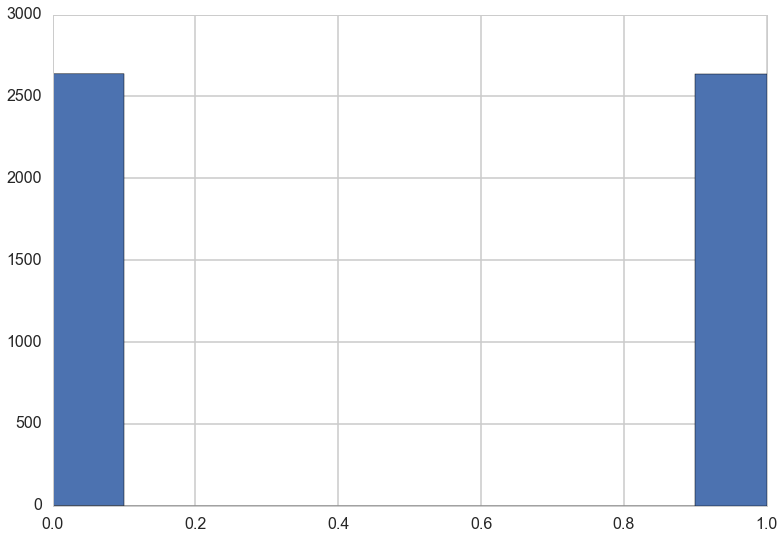

In [52]:
dftomodel_youngf = pd.read_csv('dftomodel_femaleunder25.csv')
dftomodel_youngf.drop('Unnamed: 0', axis=1, inplace=True)

# build training and test sets
itrain, itest = train_test_split(xrange(dftomodel_youngf.shape[0]), train_size=0.7, 
                                 random_state=321)
mask = np.ones(dftomodel_youngf.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask==1)

# standardize predictors
working_df = dftomodel_youngf[STANDARDIZABLE].copy()
df_train = working_df[mask]
df_test = working_df[~mask]

std_scale = preprocessing.StandardScaler().fit(df_train)
train_std = std_scale.transform(df_train)
test_std = std_scale.transform(df_test)

working_df[mask] = train_std
working_df[~mask] = test_std

dftomodel_youngf[STANDARDIZABLE] = working_df

# drop extra variables, and look at response variable to check if balanced
dftomodel_youngf = dftomodel_youngf.drop(extra_vars, axis=1)
plt.hist(dftomodel_youngf[RESP]);

In [53]:
# fit logistic regression model
clflog_youngf = LogisticRegression(penalty="l1", random_state=543)

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
clflog_youngf, Xtrain, ytrain, Xtest, ytest = do_classify(clflog_youngf, parameters, 
                                                        dftomodel_youngf, lcols,
                                                        RESP, 1, mask=mask)

using mask
BEST {'C': 10} 0.621445978879 [mean: 0.50690, std: 0.00027, params: {'C': 0.0001}, mean: 0.50690, std: 0.00027, params: {'C': 0.001}, mean: 0.53967, std: 0.03235, params: {'C': 0.01}, mean: 0.60899, std: 0.01713, params: {'C': 0.1}, mean: 0.61820, std: 0.00906, params: {'C': 1}, mean: 0.62145, std: 0.01260, params: {'C': 10}, mean: 0.61982, std: 0.01274, params: {'C': 100}, mean: 0.62009, std: 0.01308, params: {'C': 1000}, mean: 0.62009, std: 0.01308, params: {'C': 10000}, mean: 0.62009, std: 0.01308, params: {'C': 100000}]
############# based on standard predict ################
Accuracy on training data: 0.65
Accuracy on test data:     0.61
[[531 235]
 [376 441]]
########################################################


/Users/K-Lo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [54]:
# save dataframe of coefficients from logistic regression model obtained from CV at best "C"
coefdf_youngf = pd.DataFrame({
        'features': lcols,
        'youngfemale_coeffs': clflog_youngf.coef_[0]
        })

# sort by coefficient
sortedcoef_youngf = coefdf_youngf.sort(coefdf_youngf.columns[1], ascending=False)
sortedcoef_youngf

,features,youngfemale_coeffs
47,i_p_veteran,1.715639
44,i_p_speak_english,1.274926
45,i_p_stem_occupation,1.195440
52,int_hh_num_mothers,0.737626
23,i_hh_stem,0.573610
37,i_p_race_asian,0.536490
11,i_hh_food_stamp,0.500216
22,i_hh_speak_english,0.473518
19,i_hh_own_house,0.433895
32,i_p_health_insurance,0.300201


With respect to top positive factors, the top 6 are the same, with the number of mothers being ranked slightly higher than being of asian descent, compared to the overall female group (all ages).

With respect to top negative factors, three of the top 5 are the same. It is interesting to see that if the young individual is married (ranked 6th from the bottom) or is self-employed, and is going to college, they seem less likely to be studying in a STEM field.

# summary

We present a summary chart of the coefficients for the models of four groups of college students, which include our primary group of interest (female students, all ages), as well as male students (all ages), and females split by age (over 25, 25 and under). These coefficients are suggestive of the effect on the odds that the student is predicted to be studying in a STEM field or not.

Note that we are providing point estimates here for general comparison purposes; if we wanted more exact comparisons, we can calculate confidence intervals (using standard error measurements - requires a different package) for these coefficients. This may be the subject of future investigation.

In [55]:
coef = pd.merge(left=coefdf, right=coefdf_male)
coef = pd.merge(left=coef, right=coefdf_oldf)
coef = pd.merge(left=coef, right=coefdf_youngf)
coef

,features,female_coeffs,male_coeffs,olderfemale_coeffs,youngfemale_coeffs
0,cont_hh_cost_elec,-0.022439,-0.035629,-0.046420,0.092379
1,cont_hh_cost_gas,-0.002007,0.012633,0.009284,-0.001760
2,cont_hh_cost_water,-0.051041,0.034339,0.026621,-0.113055
3,cont_hh_house_value,-0.066562,-0.021981,0.000000,-0.174215
4,cont_hh_income,0.026975,-0.055102,0.004082,0.081213
5,cont_hh_rent,-0.103983,0.000000,-0.086107,0.051379
6,cont_p_income,-0.000291,0.000000,0.000000,-0.033010
7,cont_p_perc_poverty_threshold,-0.065639,0.000573,0.028342,-0.176745
8,i_hh_college_degree,0.072353,-0.070619,-0.007329,-0.026724
9,i_hh_disability,-0.270402,-0.070603,-0.118537,-0.144832


In [56]:
# coef.to_csv("coef.csv")

![](images/compare_bars.png)

![](images/highlight_table.png)

![](images/horiz_bars.png)